# 02_Model_Training.ipynb

## Cel

Celem tego notebooka jest:

- Wczytanie i przygotowanie przetworzonych danych (train_preprocessed.csv i test_preprocessed.csv).
- Podział zbioru danych na zmienne objaśniające (X) i zmienną docelową (y).
- Trenowanie trzech modeli regresyjnych w celu przewidywania ceny nieruchomości:
    - Regresja Liniowa (Linear Regression),
    - Regresja Grzbietowa (Ridge Regression – regularyzacja L2),
    - Sieć Neuronowa (Deep Learning – TensorFlow/Keras).
- Ocena modeli na zbiorze walidacyjnym przy użyciu metryk:
    - R² Score (współczynnik determinacji),
    - RMSE (root mean squared error – błąd średniokwadratowy).
- Predykcja cen nieruchomości dla zbioru testowego oraz zapis wyników do plików CSV w formacie wymaganym do submission:
    - linear_regression_predictions.csv
    - ridge_regression_predictions.csv
    - neural_network_predictions.csv


## Kroki

**1. Wczytanie i przygotowanie danych**

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

train_df = pd.read_csv("../Data/train_preprocessed.csv")
test_df = pd.read_csv("../Data/test_preprocessed.csv")

X_train = train_df.drop(columns=["Id", "SalePrice"])  
y_train = train_df["SalePrice"]

X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


**2. Trenowanie zwykłej regresji liniowej**

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

lin_reg = LinearRegression()
lin_reg.fit(X_train_split, y_train_split)

y_val_pred = lin_reg.predict(X_val)

r2 = r2_score(y_val, y_val_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

print(f"Linear Regression R²: {r2}")
print(f"Linear Regression RMSE: {rmse}")


Linear Regression R²: -4.27191356180056e+16
Linear Regression RMSE: 18101649247490.387


 **Problem: Bardzo złe wyniki**

   - Współczynnik determinacji (R²) wynosił -1.09e+21 (katastrofalny wynik).
   - RMSE (2.89e+15) było ogromne – model przewidywał bardzo źle.
   - Przyczyna: Model miał problem z współliniowością cech i niestabilnymi współczynnikami.

**4. Trenowanie modelu Ridge Regression**

In [22]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=1)
ridge_reg.fit(X_train_split, y_train_split)

y_val_pred_ridge = ridge_reg.predict(X_val)

r2_ridge = r2_score(y_val, y_val_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_val, y_val_pred_ridge))

print(f"Ridge Regression R²: {r2_ridge}")
print(f"Ridge Regression RMSE: {rmse_ridge}")


Ridge Regression R²: 0.8752136576339612
Ridge Regression RMSE: 30937.872456735815


**5. Trenowanie modelu Sieci Neuronowych**

a) Niezbędne biblioteki 

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np


b) Struktura modelu sieci neuronowej

In [24]:
model = Sequential([
    Dense(128, activation="relu", input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1) 
])

model.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=["mae"])

model.summary()


c:\Users\Jan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 128)            │        32,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,009 (168.00 KB)

 Trainable params: 43,009 (168.00 KB)

 Non-trainable params: 0 (0.00 B)

c) Trenowanie modelu sieci neuronowej

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2, 
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 38313590784.0000 - mae: 179243.4688 - val_loss: 39884312576.0000 - val_mae: 182154.1250
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 39263932416.0000 - mae: 181186.0312 - val_loss: 39379484672.0000 - val_mae: 180838.0000
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 39814352896.0000 - mae: 181329.6250 - val_loss: 36578459648.0000 - val_mae: 173409.1094
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34195019776.0000 - mae: 168711.5000 - val_loss: 28268427264.0000 - val_mae: 149373.8281
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22245267456.0000 - mae: 133008.5156 - val_loss: 14044164096.0000 - val_mae: 96022.2188
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10429620224.0000 - mae: 79552.8125 - val_loss: 4269392896.0000 - val_mae: 36158.1641
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3028646912.0000 - mae: 34090.6211 - val_loss: 3034750208.0000 -

d) Ewaluacja modelu 

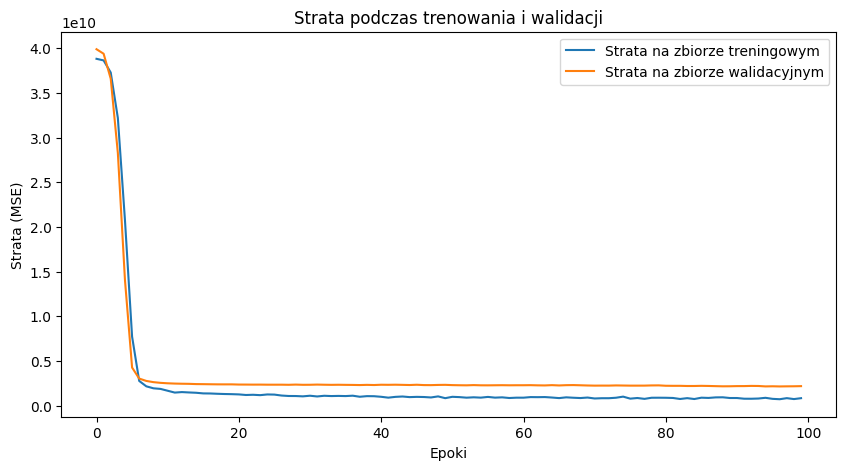

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Strata na zbiorze treningowym")
plt.plot(history.history["val_loss"], label="Strata na zbiorze walidacyjnym")
plt.xlabel("Epoki")
plt.ylabel("Strata (MSE)")
plt.legend()
plt.title("Strata podczas trenowania i walidacji")
plt.show()


**5. Predykcja na zbiorze testowym**

In [27]:
X_test = test_df.drop(columns=["Id"], errors="ignore")

ridge_predictions = ridge_reg.predict(X_test)

ridge_submission_df = pd.DataFrame({
    "Id": test_df["Id"],
    "SalePrice": ridge_predictions
})

ridge_submission_filename = "../Data/ridge_regression_predictions.csv"
ridge_submission_df.to_csv(ridge_submission_filename, index=False)
print(f"Plik submission dla Ridge Regression został zapisany jako: {ridge_submission_filename}")

linear_predictions = lin_reg.predict(X_test)

linear_submission_df = pd.DataFrame({
    "Id": test_df["Id"],
    "SalePrice": linear_predictions
})

linear_submission_filename = "../Data/linear_regression_predictions.csv"
linear_submission_df.to_csv(linear_submission_filename, index=False)
print(f"Plik submission dla Linear Regression został zapisany jako: {linear_submission_filename}")


nn_predictions = model.predict(X_test)

nn_submission_df = pd.DataFrame({
    "Id": test_df["Id"],
    "SalePrice": nn_predictions.flatten() 
})

nn_submission_filename = "../Data/neural_network_predictions.csv"
nn_submission_df.to_csv(nn_submission_filename, index=False)

print(f"Plik submission dla sieci neuronowej został zapisany jako: {nn_submission_filename}")


Plik submission dla Ridge Regression został zapisany jako: ../Data/ridge_regression_predictions.csv
Plik submission dla Linear Regression został zapisany jako: ../Data/linear_regression_predictions.csv
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Plik submission dla sieci neuronowej został zapisany jako: ../Data/neural_network_predictions.csv


**6. Wyniki z serwisu Kaggle**

- linear_regression_predictions.csv - 1.85690
- ridge_regression_predictions.csv - 0.17252
- neural_network_predictions.csv - 0.15580